# Machine Learning II Project - Customer Segmentation


Group 17
- Joel Mendes - 20221825
- Lourenço Martins - 20222043
- Margarida Sardinha - 20221959

This project's goal is to segment a fictional retail company's customers into clusters, based on their demographic and purchasing data, and then create targeted promotions for each cluster detected.

This jupyter noteboook includes all functions and code that is required for our clustering solution, and that is the basis for the coupons and promotions created.

## Importing data and libraries

In [ ]:
'''pip install umap-learn
pip install pyECLAT'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Importing functions
from sklearn.metrics import confusion_matrix, silhouette_score
from scipy.spatial.distance import pdist

from preprocessing_py_files.preprocessing import *
from preprocessing_py_files.feature_engineering import *
from preprocessing_py_files.feature_selection import *

from visualization_py_files.initial_visualizations import *
from visualization_py_files.ploting import *

from modeling_py_files.apriori_clusters import *
from modeling_py_files.dimensionality_reduction import *
from modeling_py_files.modeling import *
from modeling_py_files.association_rules import *

from extra_py_files.ExtraCredit import *
from extra_py_files.helping_functions import *

            0         1          2          3 cluster
0   -2.182270  8.795186   5.469284  -0.237966       B
1    3.698693  3.215945 -10.741661  10.535512       A
2   -7.254824 -7.197825  -7.556684   7.881214       A
3   -3.186120  9.625962   5.670878   2.904450       B
4    2.279499  3.920786  -9.580430   9.072586       A
..        ...       ...        ...        ...     ...
995 -6.423739 -4.715107  -9.481846   8.251363       A
996  1.512494  4.195893 -12.076637   8.739949       A
997  3.123122  5.222823  -9.056304   9.759858       A
998  1.133059  5.116752  -8.712263  10.870868       A
999  1.165802  4.259122 -10.852809   7.605091       A

[1000 rows x 5 columns]


In [2]:
cust_basket = pd.read_csv('data/customer_basket.csv')
cust_info = pd.read_csv('data/customer_info.csv', index_col=0)
product_mapping = pd.read_excel('data/product_mapping.xlsx')

## Exploratory Data Analysis

The first step of any ML project is to clean and visualize the data one is working with. This, in our case, included creating variables and removing unwanted ones, scaling all numerical variables, and removing outliers, both random and those that form clusters a priori.

In [3]:
# Initial visualizations
display(cust_info.head())
display(cust_info.info())
display(cust_info.describe())
display(cust_info.describe(include=object))

display(cust_basket.head())
display(cust_basket.info())
display(cust_basket.describe())
display(cust_basket.describe(include=object))

product_mapping

,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,39634,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,7106.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
1,43460,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,1334.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
2,23937,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,4073.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105
3,2431,Ora Boggess,female,06/15/1941 03:26 AM,0.0,0.0,0.0,1.0,10825.0,207.0,...,151.0,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318
4,10090,Lonnie Hopson,male,12/18/2001 03:03 AM,0.0,0.0,0.0,1.0,697.0,570.0,...,172.0,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024


<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 0 to 43630
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_id                              43631 non-null  int64  
 1   customer_name                            43631 non-null  object 
 2   customer_gender                          43631 non-null  object 
 3   customer_birthdate                       43631 non-null  object 
 4   kids_home                                43107 non-null  float64
 5   teens_home                               42610 non-null  float64
 6   number_complaints                        42977 non-null  float64
 7   distinct_stores_visited                  42322 non-null  float64
 8   lifetime_spend_groceries                 43631 non-null  float64
 9   lifetime_spend_electronics               43631 non-null  float64
 10  typical_hour                             41886 non-

None

,customer_id,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
count,43631.000000,43107.000000,42610.000000,42977.000000,42322.000000,43631.000000,43631.000000,41886.000000,42758.000000,43631.000000,...,42322.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,24654.000000,43631.000000,43631.000000
mean,24993.120877,1.081263,0.847829,0.705726,1.669959,5600.030047,2000.058468,13.520580,456.893938,443.636657,...,1471.423846,916.948408,990.334922,2023.225619,387.260182,0.229431,2011.342257,949808.661069,38.752266,-9.158591
std,14426.310863,1.239257,0.840397,0.624624,1.034825,4602.647746,3004.924537,4.558057,312.832282,210.313287,...,3910.163766,729.744050,1241.658577,2926.355387,411.436756,0.189242,4.656129,28894.251301,0.048629,0.036606
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.477986,1996.000000,900008.000000,38.690636,-9.418076
25%,12521.500000,0.000000,0.000000,0.000000,1.000000,2184.500000,218.000000,10.000000,227.000000,297.000000,...,187.000000,372.000000,204.000000,517.000000,97.000000,0.111704,2008.000000,924774.000000,38.732481,-9.175824
50%,24988.000000,1.000000,1.000000,1.000000,1.000000,4071.000000,574.000000,13.000000,387.000000,419.000000,...,641.000000,668.000000,557.000000,874.000000,252.000000,0.205235,2011.000000,949681.000000,38.748887,-9.160152
75%,37484.500000,1.000000,1.000000,1.000000,2.000000,6605.500000,2565.500000,17.000000,584.000000,560.000000,...,1570.000000,1437.000000,1111.000000,2217.000000,537.000000,0.310884,2014.000000,975117.250000,38.764504,-9.139240
max,50000.000000,9.000000,6.000000,9.000000,8.000000,26552.000000,21273.000000,24.000000,2112.000000,2224.000000,...,50381.000000,3487.000000,5389.000000,19596.000000,3544.000000,1.196858,2024.000000,999996.000000,39.357600,-9.055377


,customer_name,customer_gender,customer_birthdate
count,43631,43631,43631
unique,42351,2,43594
top,James Brown,female,08/13/1962 08:48 PM
freq,10,21910,2


,invoice_id,list_of_goods,customer_id
0,7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
1,3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
2,10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134
3,12179179,"['babies food', 'milk', 'rice', 'yogurt cake',...",43134
4,8292388,"['napkins', 'cookies', 'razor', 'cooking oil',...",43134


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89952 entries, 0 to 89951
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   invoice_id     89952 non-null  int64 
 1   list_of_goods  89952 non-null  object
 2   customer_id    89952 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


None

,invoice_id,customer_id
count,8.995200e+04,89952.000000
mean,6.126259e+06,21855.193915
std,3.527265e+06,12610.661213
min,2.006600e+04,1.000000
25%,3.085110e+06,10814.000000
50%,6.133909e+06,21904.000000
75%,9.185876e+06,32771.000000
max,1.224224e+07,43631.000000


,list_of_goods
count,89952
unique,88767
top,"['babies food', 'cooking oil']"
freq,25


,product_name,category
0,champagne,alcohol_drinks
1,bramble,alcohol_drinks
2,white wine,alcohol_drinks
3,dessert wine,alcohol_drinks
4,french wine,alcohol_drinks
...,...,...
160,final fantasy XX,videogames
161,final fantasy XIX,videogames
162,final fantasy XXII,videogames
163,dog food,pet food


#### Inconsistencies found

In [4]:
# Variables with missing values
cust_info.isnull().sum()

customer_id                                    0
customer_name                                  0
customer_gender                                0
customer_birthdate                             0
kids_home                                    524
teens_home                                  1021
number_complaints                            654
distinct_stores_visited                     1309
lifetime_spend_groceries                       0
lifetime_spend_electronics                     0
typical_hour                                1745
lifetime_spend_vegetables                    873
lifetime_spend_nonalcohol_drinks               0
lifetime_spend_alcohol_drinks                  0
lifetime_spend_meat                            0
lifetime_spend_fish                         1309
lifetime_spend_hygiene                         0
lifetime_spend_videogames                      0
lifetime_spend_petfood                         0
lifetime_total_distinct_products               0
percentage_of_produc

In [5]:
# A percentage cannot be negative
cust_info['percentage_of_products_bought_promotion'].min()

-0.4779855680623625

### Preprocessing

In [3]:
# Applying the preproc functions to customer_info
info_treated = custinfo_feature_eng(cust_info)
info_scaled = scaling_imputation(info_treated)

In [4]:
# Applying the preproc functions to customer_basket
basket_treated = cust_basket_preproc(cust_basket)
basket_encoded = cust_basket_encoding(basket_treated)

We end up with the following dataframes:

* *info_treated* - Unscaled, but with the new features, to be used in interpretation of clusters. The cluster labels will be added here.
* *info_scaled* - Scaled with Robust Scaler, with missing values imputed with KNN, to be used for modelling
* *basket_treated* - Cleaned up, to serve as reference if needed
* *basket_encoded* - With TransactionEncoded applied, to be used for association rules

### Visualizations

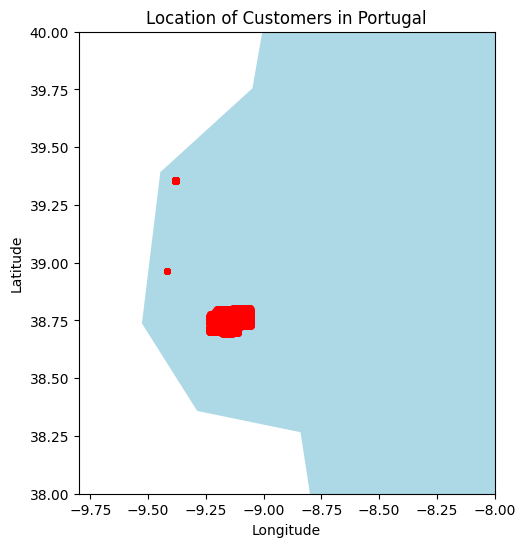

In [6]:
plot_population(cust_info)

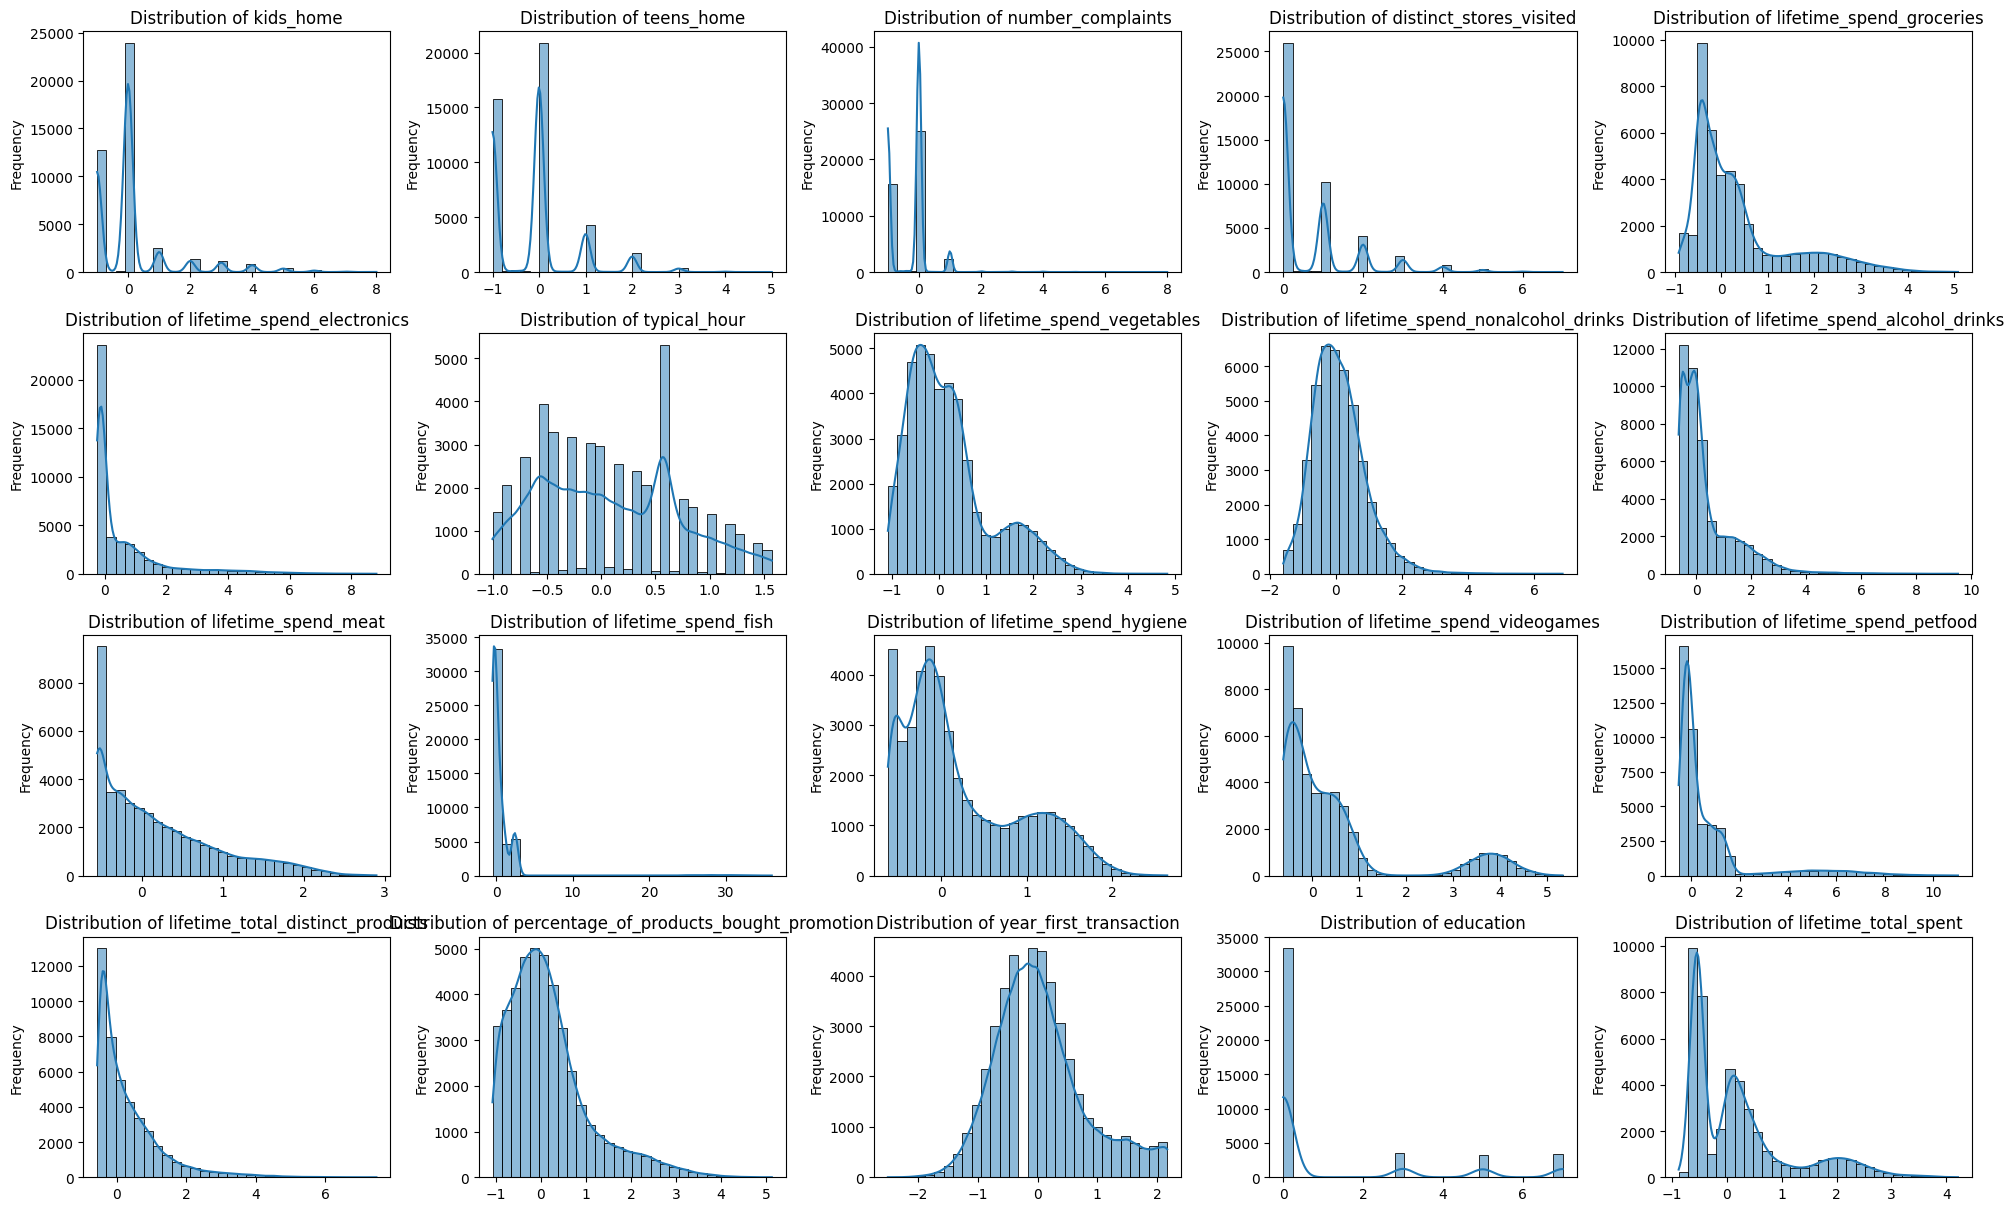

In [8]:
plot_distributions_grid(info_treated, ['customer_name', 'age', 'gender', 'vegetarian', 'latitude', 'longitude'], figsize=(20, 15), bins=30)

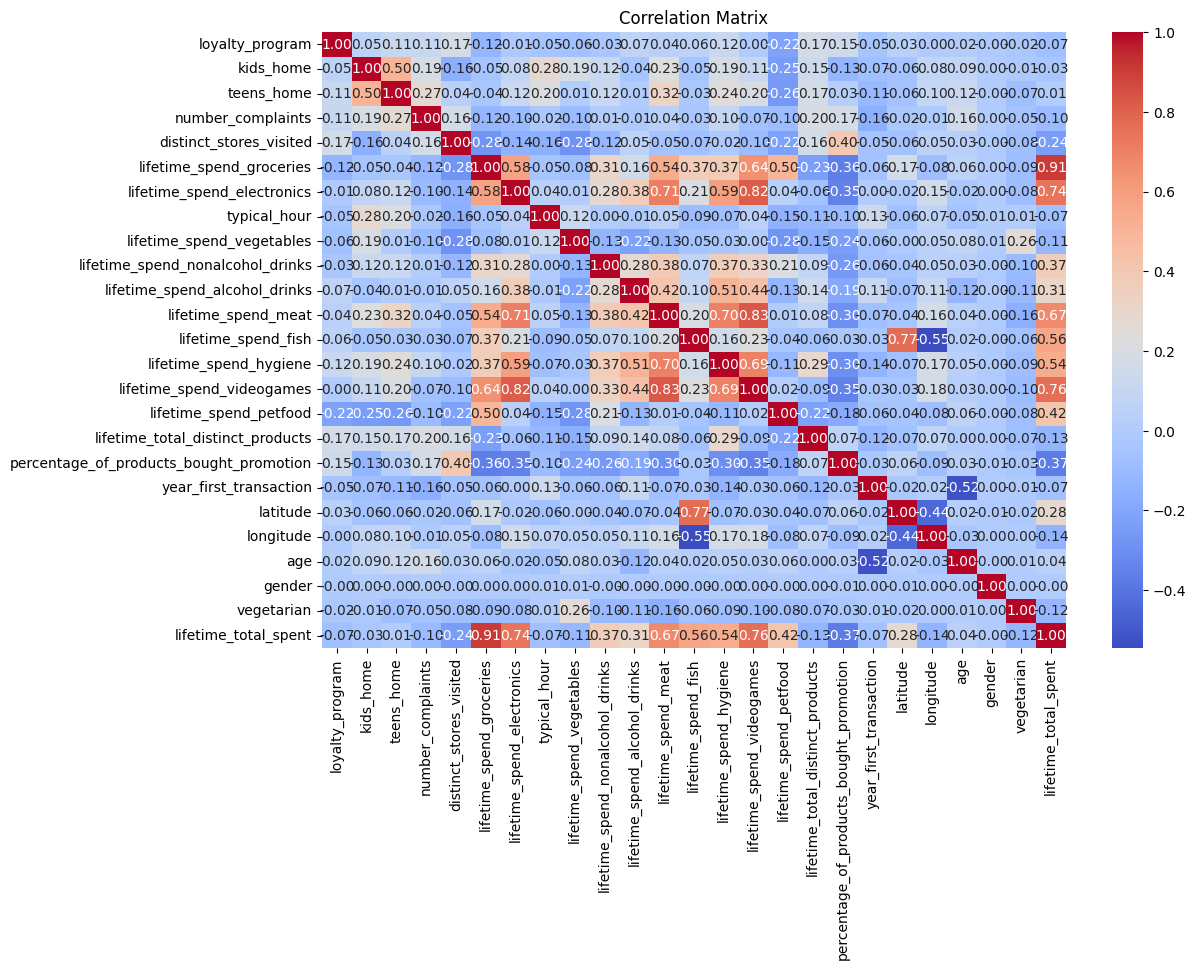

In [9]:
plot_variable_correlation(info_scaled, ['customer_name', 'education'])

### Feature Selection

Based on the results above, here we remove the unwanted features, those that were too highly correlated and thus worked as proxies for another.

In [5]:
info_scaled = feature_selection(info_scaled)

## Customer Segmentation

### Preparing the data

To apply to the clustering algorithms, only the variables relating to purchase history will be used.

The initial plan was to create 2 clustering solutions and merge them based on results, but due to time constraints, only the most relevant variables, the ones relating to purchase history, will be used. In future, the project could be expanded upon by utilizing the demographic variables as well.

In [6]:
modeldf_purchase, modeldf_demog = custinfo_separator(info_scaled)

### K-Means Clustering

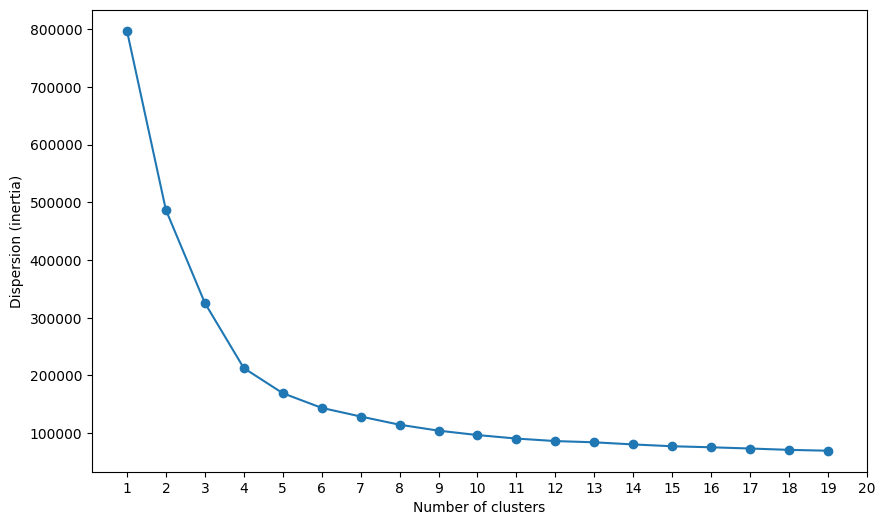

In [12]:
# Checking the optimum number of clusters to look for
dispersion = create_dispersion_list(modeldf_purchase)
plot_elbow_graph(dispersion)

In [7]:
allocate_clusters_kmeans(info_treated, modeldf_purchase, n_clusters=7)

<Figure size 1400x800 with 0 Axes>

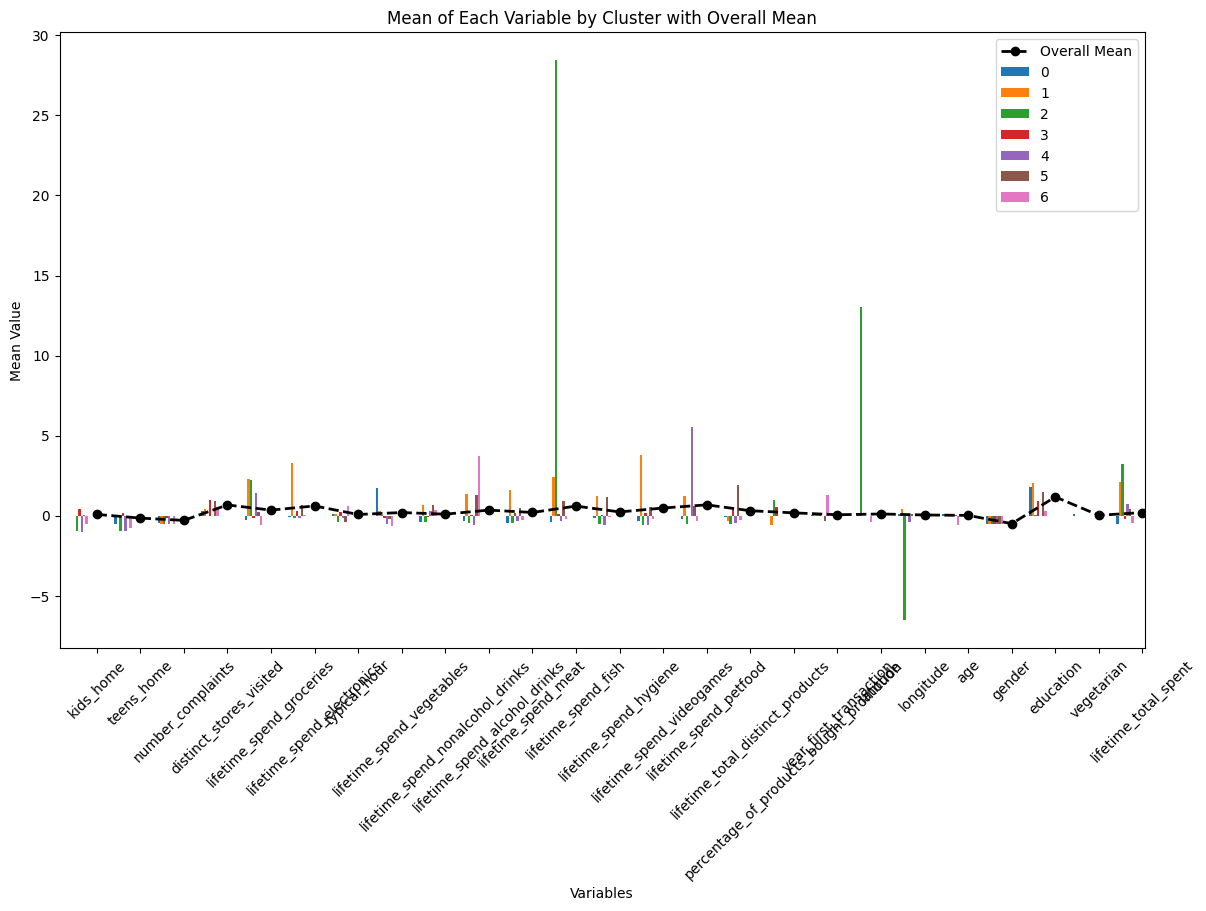

In [14]:
plot_cluster_description(info_treated)

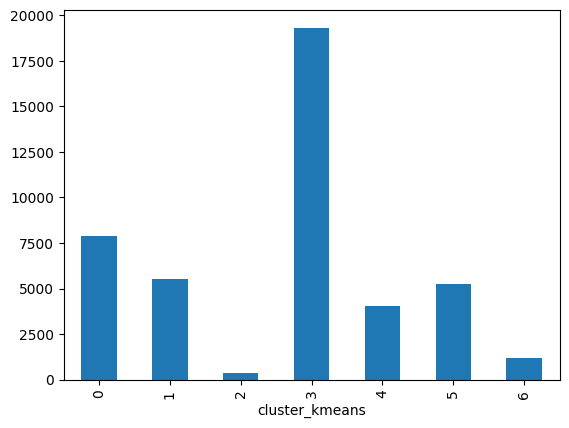

In [8]:
plot_cluster_sizes(info_treated, 'cluster_kmeans')

### Hierarchical Clustering

In [9]:
from scipy.spatial.distance import pdist

In [10]:
distances = pdist(modeldf_purchase)
avg_dist = np.mean(distances)

In [13]:
agg_clust = create_agg_clusters(modeldf_purchase, distance_threshold=avg_dist*0.75)

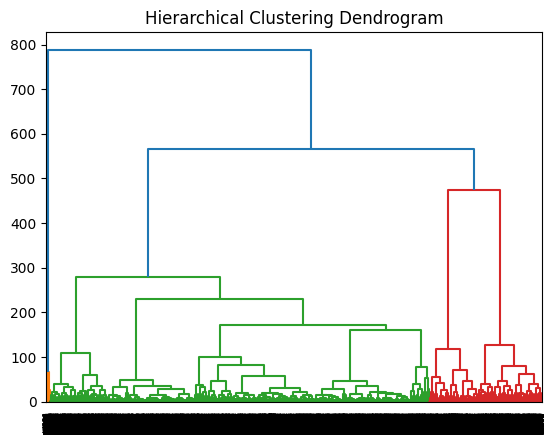

In [14]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.show()

In [14]:
allocate_clusters_hierarchical(info_treated, modeldf_purchase, n_clusters=8)

: 

: 

In [ ]:
info_treated.groupby(['cluster_hierarchical']).mean()

In [ ]:
info_treated.mean()

In [ ]:
pd.DataFrame(
    confusion_matrix(info_treated.cluster_kmeans, info_treated.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,8)],
    columns = ['Ward {} Cluster'.format(i) for i in np.arange(0,8)],
)

In [ ]:
modeldf_purchase.groupby(['cluster_hierarchical']).size().plot(kind='bar')
plt.show()

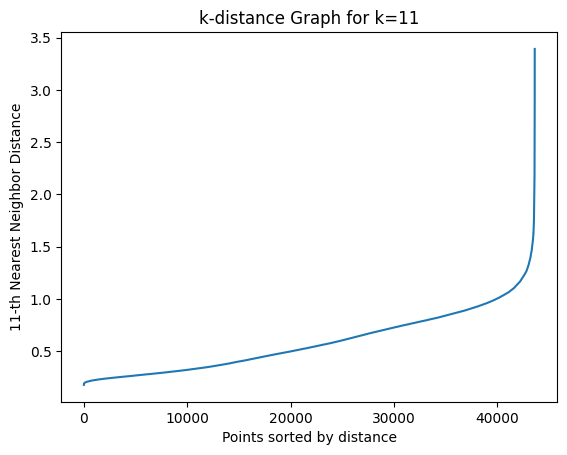

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'k-distance Graph for k={k}')
    plt.show()

# Plot the k-distance graph
plot_k_distance(modeldf_purchase, k=11)

In [16]:
from scipy.spatial import distance_matrix

# Calculate the distance matrix
dist_matrix = distance_matrix(modeldf_purchase, modeldf_purchase)

# Summary statistics of pairwise distances
print('Min distance:', np.min(dist_matrix))
print('Max distance:', np.max(dist_matrix))
print('Mean distance:', np.mean(dist_matrix))
print('Median distance:', np.median(dist_matrix))

Min distance: 0.0
Max distance: 38.29788327327018
Mean distance: 4.607739242156588
Median distance: 3.796718062079621


In [17]:
modeldf_purchase.shape

(43631, 10)

### DBSCAN

In [19]:
eps_range = np.arange(0.7, 1.2, 0.1)
min_samples_range = range(10, 40, 5)

# Function to calculate and print cluster sizes and noise points
def print_cluster_info(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_info = dict(zip(unique_labels, counts))

    noise_points = cluster_info.get(-1, 0)
    clusters = {k: v for k, v in cluster_info.items() if k != -1}

    return clusters, noise_points

# Grid search over the parameter ranges
for min_samples in min_samples_range:
    for eps_val in eps_range:
        model = DBSCAN(eps=eps_val, min_samples=min_samples)
        labels = model.fit_predict(modeldf_purchase)

        clusters, noise_points = print_cluster_info(labels)

        if noise_points <= 5000:
            print(f'eps: {round(eps_val,2)}, min_samples: {min_samples}')
            print(f'Cluster sizes: {clusters}')
            print(f'Number of noise points: {noise_points}')
            print('-' * 40)

eps: 0.9, min_samples: 10
Cluster sizes: {0: 4637, 1: 36383, 2: 340, 3: 13, 4: 11, 5: 6}
Number of noise points: 2241
----------------------------------------
eps: 1.0, min_samples: 10
Cluster sizes: {0: 5202, 1: 37065, 2: 357}
Number of noise points: 1007
----------------------------------------
eps: 1.1, min_samples: 10
Cluster sizes: {0: 42778, 1: 361}
Number of noise points: 492
----------------------------------------
eps: 0.9, min_samples: 15
Cluster sizes: {0: 4250, 1: 4230, 2: 31784, 3: 318, 4: 6}
Number of noise points: 3043
----------------------------------------
eps: 1.0, min_samples: 15
Cluster sizes: {0: 5057, 1: 36878, 2: 343}
Number of noise points: 1353
----------------------------------------
eps: 1.1, min_samples: 15
Cluster sizes: {0: 42628, 1: 353}
Number of noise points: 650
----------------------------------------
eps: 0.9, min_samples: 20
Cluster sizes: {0: 3795, 1: 4214, 2: 31493, 3: 278}
Number of noise points: 3851
----------------------------------------
eps

In [21]:
allocate_clusters_dbscan(info_treated, modeldf_purchase, eps=1, min_samples=30)

info_treated.select_dtypes(include=[np.number]).groupby(['cluster_dbscan']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,age,gender,education,vegetarian,lifetime_total_spent,cluster_kmeans
cluster_dbscan,,,,,,,,,,,,,,,,,,,,,
-1,-0.073413,-0.154365,-0.205317,0.672302,1.119907,1.836657,-0.038220,0.256519,0.748042,1.440738,...,-0.184492,-0.007275,0.667674,-0.125810,0.082873,-0.483730,1.378175,0.000000,1.175304,2.688889
0,0.001606,-0.005085,-0.504505,0.386128,2.252727,3.120469,0.090748,0.314890,0.686748,1.335949,...,-0.601856,0.024978,0.096394,0.379237,0.086537,-0.503122,2.010036,0.000000,2.049855,1.020517
1,-1.000000,-0.987962,-0.495498,0.000000,1.374022,-0.176423,-0.161774,-0.528306,0.303863,-0.558149,...,-0.033560,0.008649,-0.005516,-0.372761,0.090216,-0.494076,0.000000,0.000000,0.678524,3.954976
2,0.254299,-0.056160,-0.244008,0.803161,-0.131145,0.269778,0.115976,0.272262,-0.063864,0.249180,...,0.332938,0.073077,-0.028557,0.117145,-0.007709,-0.498569,1.198700,0.030363,-0.228020,2.650977
3,-0.963636,-0.974747,-0.480808,0.000000,2.221648,-0.167916,-0.406061,-0.055700,-0.379364,-0.443144,...,1.051855,0.049663,12.773199,-6.539337,0.079505,-0.545455,0.025253,0.000000,3.367227,2.000000
4,-0.984615,-0.950769,-0.581538,0.000000,2.214125,-0.147686,-0.529670,-0.158285,-0.486341,-0.428957,...,0.864780,-0.002564,13.873239,-6.451836,0.042680,-0.415385,0.046154,0.000000,2.962590,2.000000


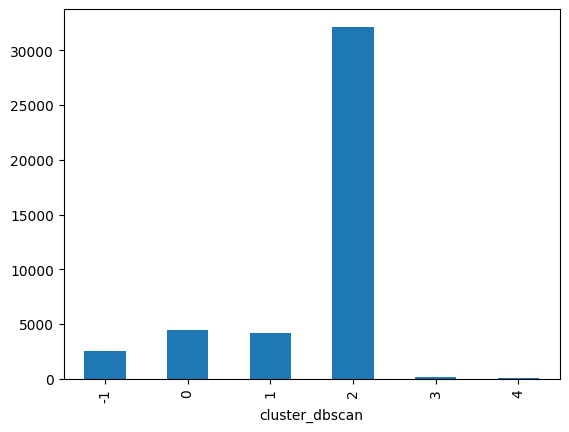

In [22]:
info_treated.groupby(['cluster_dbscan']).size().plot(kind='bar')
plt.show()

### Meanshift

In [23]:
from sklearn.cluster import estimate_bandwidth

estimate_bandwidth(modeldf_purchase, quantile=0.15)

KeyboardInterrupt: 

In [ ]:
allocate_clusters_meanshift(info_treated, modeldf_purchase, bandwidth=4)

In [ ]:
info_treated.select_dtypes(include=[np.number]).groupby(['cluster_meanshift']).mean()

In [ ]:
info_treated.groupby(['cluster_meanshift']).size().plot(kind='bar')
plt.show()

### Segment Descriptions

In [ ]:
apply_tsne(modeldf_purchase)

In [ ]:
apply_umap(modeldf_purchase)

### Segment Comparison

## Association Rules

We know it would be best to divide the dataset into train and test, and evaluate how well the rules describe the entire population, but due to time constraints this was not possible for us to do. In a future project, this would be something to improve on.

In [ ]:
cluster_dfs = association_rules_preproc(info_treated, basket_encoded)

for index in [0,6]:
    association_rules_apriori(cluster_dfs, index)

The higher the lift, the more specific the association rules are to the cluster at hand. To find better lift, we try lowering the minimum support